In [1]:
import pandas as pd
df = pd.read_csv("cleaned_dataset.csv")

The cluster containing the most valuable NFTs: 1
Original number of columns: 43122, Filtered number of columns: 63

Common Features Among the Most Valuable NFTs:

No  Common Features                                                                                      Support   
------------------------------------------------------------------------------------------------------------------------
1   Category=Virtual Worlds                                                                              0.4816    
2   payment_token.name=Decentraland MANA                                                                 0.2806    
3   Category=Virtual Worlds, payment_token.name=Decentraland MANA                                        0.2430    
4   asset.collection.name=Decentraland Wearables                                                         0.2269    
5   Category=Virtual Worlds, asset.collection.name=Decentraland Wearables                                0.2269    
6   asset.collection

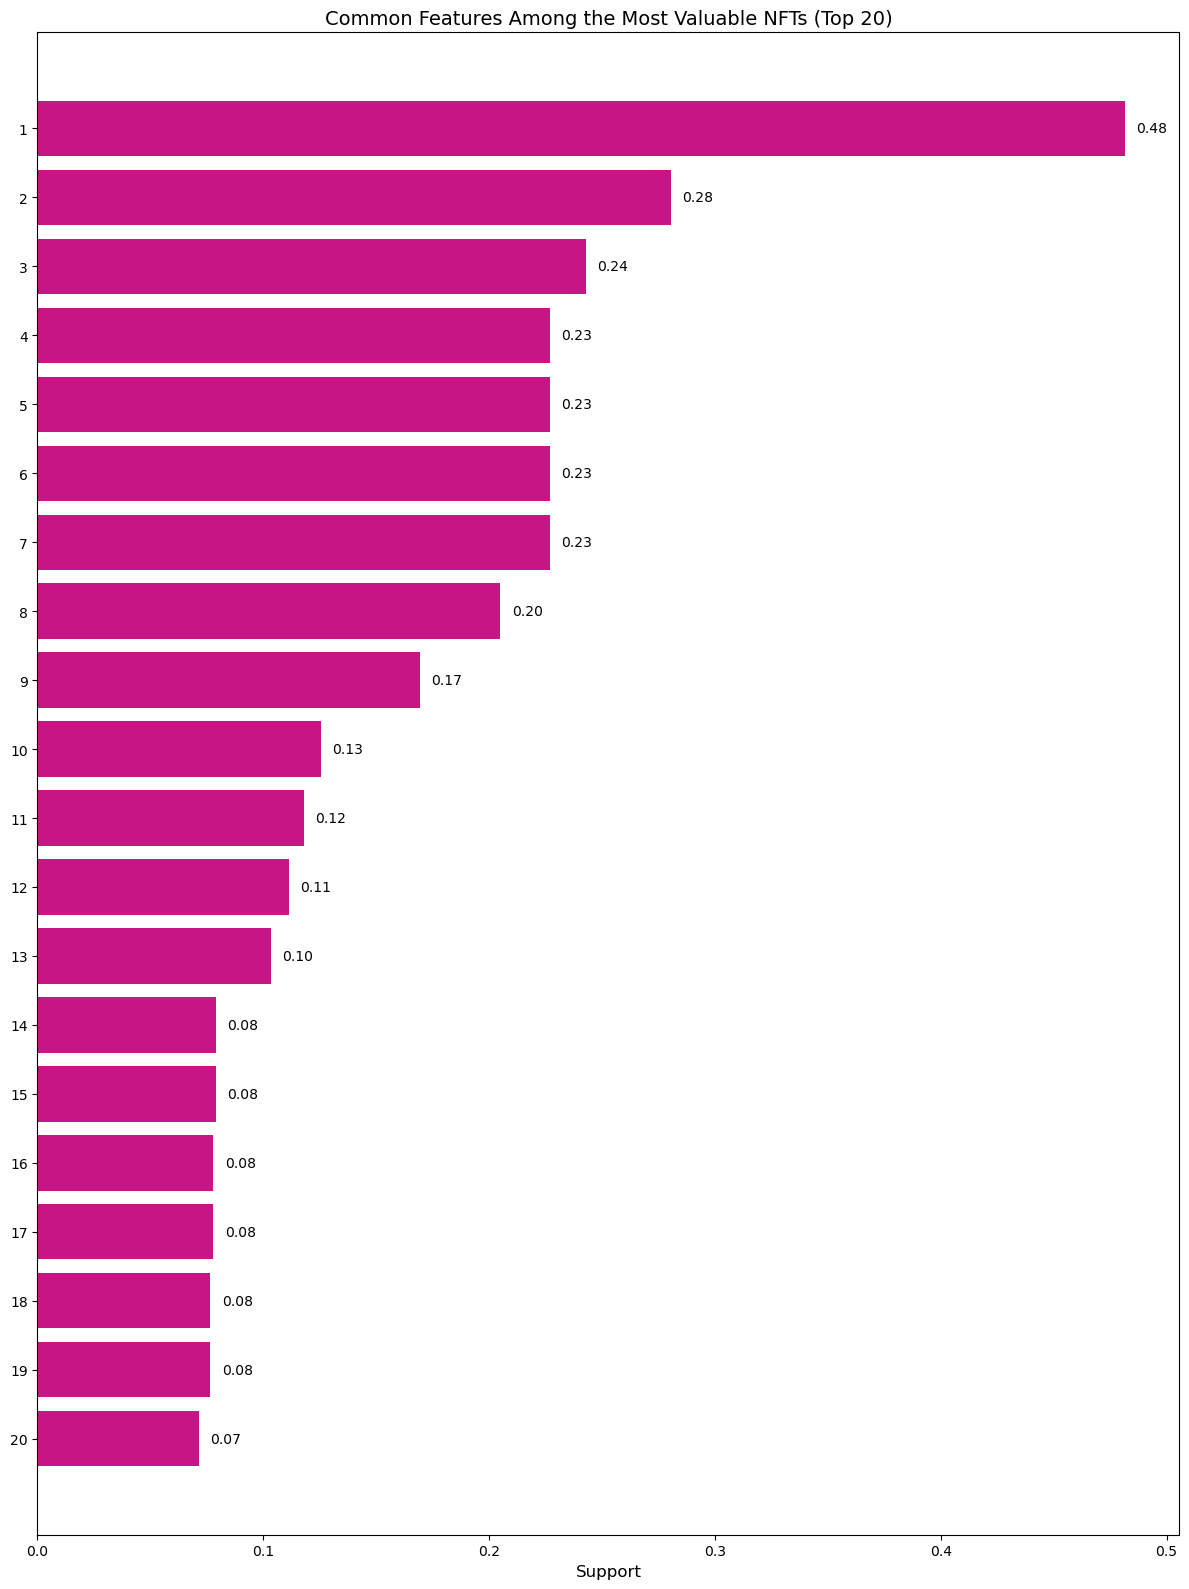

In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt


# --- 1. K-Means Clustering Using Numerical Features ---

features = ['total_price', 'asset.num_sales', 'payment_token.usd_price']
df_filtered = df[features].dropna().copy()

# Standardize features to have mean=0 and variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered)

# Apply K-Means clustering with 3 clusters and fixed random seed for reproducibility
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df_filtered['Cluster'] = clusters

# Identify the cluster with the highest average total_price (most valuable NFTs)
cluster_means = df_filtered.groupby('Cluster')['total_price'].mean()
valuable_cluster = cluster_means.idxmax()
print(f"The cluster containing the most valuable NFTs: {valuable_cluster}")

# Add cluster assignments back to the original dataframe, defaulting to -1 for unclustered rows
df['Cluster'] = -1
df.loc[df_filtered.index, 'Cluster'] = df_filtered['Cluster']

# Filter the original dataframe to include only the most valuable cluster
valuable_df = df[df['Cluster'] == valuable_cluster]

# Randomly sample 10,000 rows from the valuable cluster for further analysis
valuable_df = valuable_df.sample(n=10000, random_state=42)

# --- 2. Frequent Pattern Mining Using FP-Growth ---

# Remove numerical columns and cluster label to keep only categorical/qualitative features
drop_cols = ['Cluster', 'total_price', 'asset.num_sales', 'payment_token.usd_price']
valuable_df_cleaned = valuable_df.drop(columns=drop_cols, errors='ignore')

# Convert each row into a list of "column=value" strings for transactional encoding
transactions = valuable_df_cleaned.apply(
    lambda row: [f"{col}={row[col]}" for col in valuable_df_cleaned.columns if pd.notnull(row[col])],
    axis=1
).tolist()

# Encode the transactional data into a one-hot encoded boolean array
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_tf = pd.DataFrame(te_ary, columns=te.columns_)

# Filter out columns with very low support (less than 1%) to reduce noise and computation
min_column_support = 0.01
col_supports = df_tf.mean(axis=0)
df_tf_filtered = df_tf.loc[:, col_supports >= min_column_support]

print(f"Original number of columns: {df_tf.shape[1]}, Filtered number of columns: {df_tf_filtered.shape[1]}")

# Perform FP-Growth to find frequent itemsets with at least 5% support
frequent_itemsets = fpgrowth(df_tf_filtered, min_support=0.05, use_colnames=True)

# Sort frequent itemsets by descending support
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

# Convert frozensets to lists for easier handling and display
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(list)


# Select top 20 frequent itemsets for presentation
top_20 = frequent_itemsets.head(20).copy()
top_20.index = range(1, 21)

# Print the top 20 frequent itemsets with their support values
print("\nCommon Features Among the Most Valuable NFTs:\n")
print("{:<3} {:<100} {:<10}".format("No", "Common Features", "Support"))
print("-" * 120)
for idx, row in top_20.iterrows():
    print(f"{idx:<3} {', '.join(row['itemsets']):<100} {row['support']:<10.4f}")

# --- 3. Visualization of Top Frequent Itemsets ---

plt.figure(figsize=(12, 16))
bars = plt.barh(range(len(top_20)), top_20['support'], color='mediumvioletred')

plt.yticks(range(len(top_20)), top_20.index, fontsize=10)
plt.xlabel('Support', fontsize=12)
plt.title('Common Features Among the Most Valuable NFTs (Top 20)', fontsize=14)
plt.gca().invert_yaxis()

# Add support value labels at the end of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{top_20["support"].iloc[i]:.2f}', va='center')

plt.tight_layout()
plt.show()



Starting analysis for support = 0.2 ...
Found 5 frequent itemsets for Cluster 0.
Found 8 frequent itemsets for Cluster 1.
Found 21 frequent itemsets for Cluster 2.
Number of common itemsets across all clusters: 1


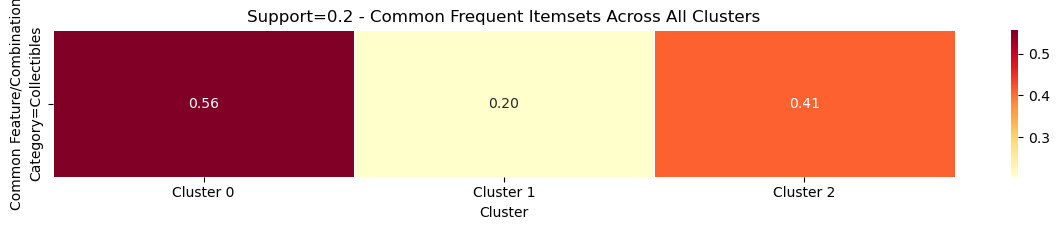


Starting analysis for support = 0.15 ...
Found 5 frequent itemsets for Cluster 0.
Found 9 frequent itemsets for Cluster 1.
Found 49 frequent itemsets for Cluster 2.
Number of common itemsets across all clusters: 1


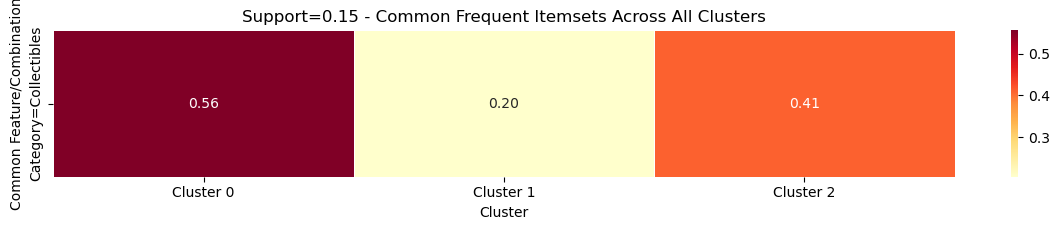


Starting analysis for support = 0.1 ...
Found 5 frequent itemsets for Cluster 0.
Found 13 frequent itemsets for Cluster 1.
Found 569 frequent itemsets for Cluster 2.
Number of common itemsets across all clusters: 1


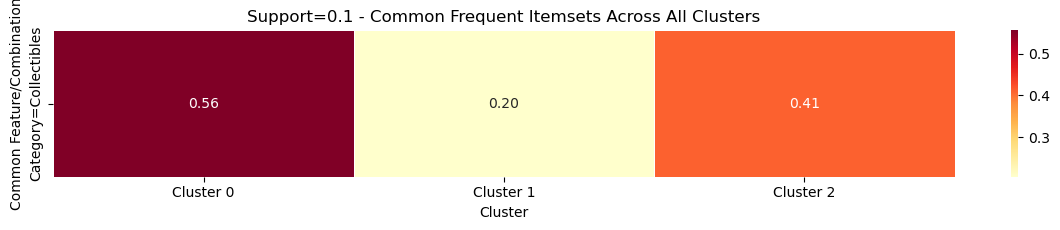


Starting analysis for support = 0.05 ...
Found 7 frequent itemsets for Cluster 0.
Found 23 frequent itemsets for Cluster 1.
Found 806 frequent itemsets for Cluster 2.
Number of common itemsets across all clusters: 2


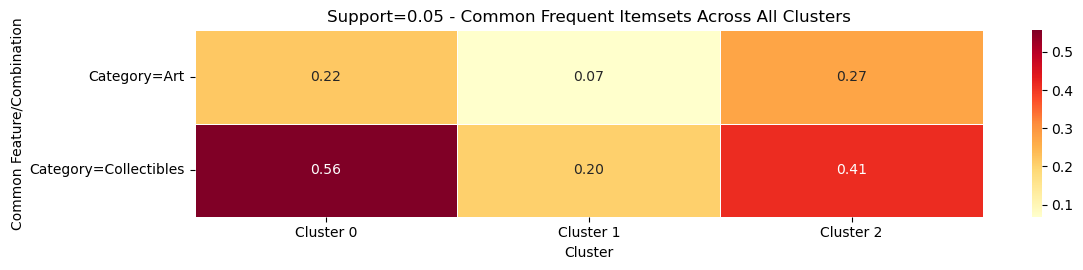


Starting analysis for support = 0.03 ...
Found 16 frequent itemsets for Cluster 0.
Found 71 frequent itemsets for Cluster 1.
Found 839 frequent itemsets for Cluster 2.
Number of common itemsets across all clusters: 2


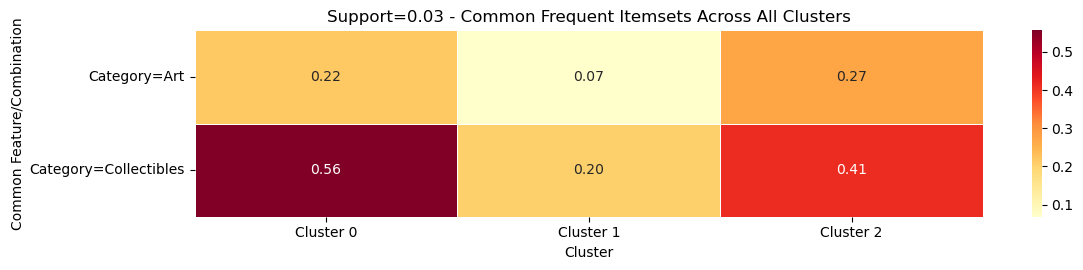


Starting analysis for support = 0.01 ...
Found 66 frequent itemsets for Cluster 0.
Found 341 frequent itemsets for Cluster 1.
Found 1484 frequent itemsets for Cluster 2.
Number of common itemsets across all clusters: 3


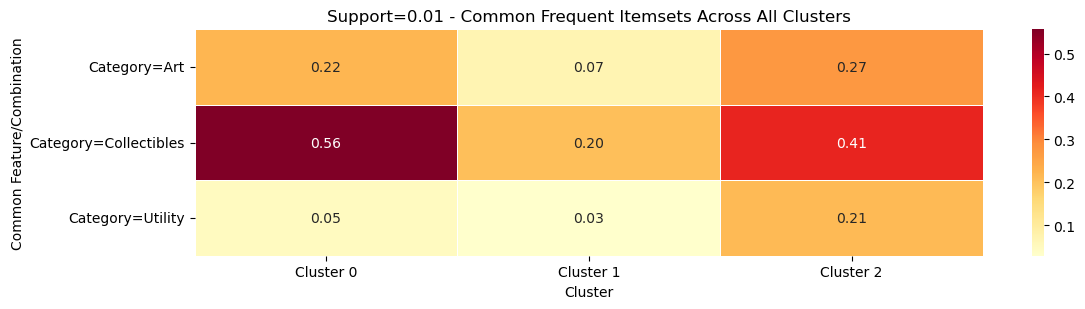

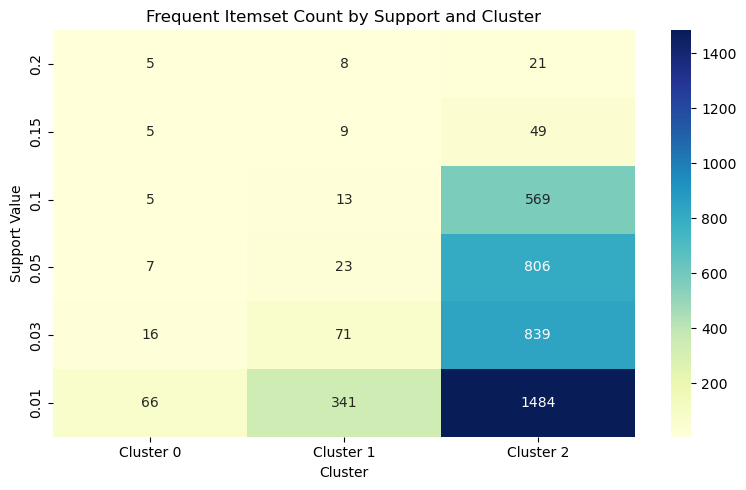

In [6]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. K-Means Clustering ---
features = ['total_price', 'asset.num_sales', 'payment_token.usd_price']
df_filtered = df[features].dropna().copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df_filtered['Cluster'] = clusters

df['Cluster'] = -1
df.loc[df_filtered.index, 'Cluster'] = df_filtered['Cluster']

# --- 2. Minimum support values for FP-Growth ---
support_values = [0.2, 0.15, 0.1, 0.05, 0.03, 0.01]
sample_size = 10000  # Sample size per cluster for performance

# --- 3. Table to store the number of frequent itemsets by cluster ---
itemset_counts_by_cluster = pd.DataFrame(index=support_values, columns=[f'Cluster {i}' for i in range(3)])

# --- 4. FP-Growth and common itemset analysis for each support value ---
for support in support_values:
    print(f"\nStarting analysis for support = {support} ...")

    cluster_itemsets_all = {}
    support_lookup = {}

    for cluster_id in range(3):
        cluster_df = df[df['Cluster'] == cluster_id]

        # Sample if the cluster has too many records (to reduce memory usage)
        if len(cluster_df) > sample_size:
            cluster_df = cluster_df.sample(n=sample_size, random_state=42)

        drop_cols = ['Cluster', 'total_price', 'asset.num_sales', 'payment_token.usd_price']
        cleaned_df = cluster_df.drop(columns=drop_cols, errors='ignore')

        # Convert each row to a transaction
        transactions = cleaned_df.apply(
            lambda row: [f"{col}={row[col]}" for col in cleaned_df.columns if pd.notnull(row[col])],
            axis=1
        ).tolist()

        # One-hot encoding
        te = TransactionEncoder()
        te_ary = te.fit(transactions).transform(transactions)
        df_tf = pd.DataFrame(te_ary, columns=te.columns_)

        # Filter out rare columns (<1% support)
        col_supports = df_tf.mean(axis=0)
        df_tf_filtered = df_tf.loc[:, col_supports >= 0.01]

        # Apply FP-Growth
        frequent_itemsets = fpgrowth(df_tf_filtered, min_support=support, use_colnames=True)
        frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(lambda x: tuple(sorted(x)))

        print(f"Found {len(frequent_itemsets)} frequent itemsets for Cluster {cluster_id}.")

        # Store the number of itemsets for heatmap summary
        itemset_counts_by_cluster.loc[support, f'Cluster {cluster_id}'] = len(frequent_itemsets)

        cluster_itemsets_all[cluster_id] = set(frequent_itemsets['itemsets'])
        support_lookup[cluster_id] = dict(zip(frequent_itemsets['itemsets'], frequent_itemsets['support']))

    # Find common itemsets across all three clusters
    common_itemsets = cluster_itemsets_all[0] & cluster_itemsets_all[1] & cluster_itemsets_all[2]
    print(f"Number of common itemsets across all clusters: {len(common_itemsets)}")

    if len(common_itemsets) == 0:
        print("No common itemsets found, skipping heatmap.")
        continue

    # --- Create heatmap data for common itemsets ---
    heatmap_data = pd.DataFrame(index=[", ".join(item) for item in sorted(common_itemsets)],
                                columns=[f'Cluster {i}' for i in range(3)])

    for cluster_id in range(3):
        for itemset in common_itemsets:
            support_val = support_lookup[cluster_id].get(itemset, 0)
            heatmap_data.loc[", ".join(itemset), f'Cluster {cluster_id}'] = support_val

    heatmap_data = heatmap_data.astype(float)

    # --- Heatmap of support values for common itemsets ---
    plt.figure(figsize=(12, len(heatmap_data) * 0.4 + 2))
    sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.2f', linewidths=0.5)
    plt.title(f'Support={support} - Common Frequent Itemsets Across All Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Common Feature/Combination')
    plt.tight_layout()
    plt.show()

# --- 5. Heatmap of Support vs. Frequent Itemset Count (after all iterations) ---
itemset_counts_by_cluster = itemset_counts_by_cluster.astype(int)

plt.figure(figsize=(8, 5))
sns.heatmap(itemset_counts_by_cluster, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Frequent Itemset Count by Support and Cluster")
plt.xlabel("Cluster")
plt.ylabel("Support Value")
plt.tight_layout()
plt.show()
